# Drift correction for AeN JC2-2 P10 GEM2, Magnaprobe and camera positions

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename, skiptherows = 18):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=skiptherows)
        
        print(gnsstrack.keys())
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [3]:
## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [4]:
glon, glat,gtimes = readbasegps("/mnt/documents/JC2-2/P10-11092021/gnss/base3-near/nav/P10-base3-day2-12092021.pos",
                               skiptherows = 14)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/documents/JC2-2/P10-11092021/gnss/base3-near/nav/P10-base3-day2-12092021.pos'

In [5]:
glat[0:5]

NameError: name 'glat' is not defined

In [12]:
gtimes[-1]

datetime.datetime(2021, 9, 12, 14, 52, 39)

In [13]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [14]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [15]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

In [16]:
glat

array([86.39373905, 86.39373884, 86.39373856, ..., 86.37904939,
       86.37904905, 86.37904862])

In [17]:
glon

array([-16.66688146, -16.66688658, -16.66689193, ..., -16.65531024,
       -16.65531073, -16.65531261])

In [18]:
gnssutm

array([[ 185463.22901685,  185463.20874428,  185463.1912987 , ...,
         186288.91765085,  186288.93227647,  186288.94289138],
       [-343966.13995836, -343966.17589627, -343966.22041129, ...,
        -345330.5218648 , -345330.55598696, -345330.60286808]])

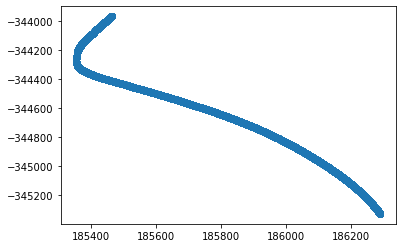

In [19]:
plt.scatter(gnssutm[0], gnssutm[1])

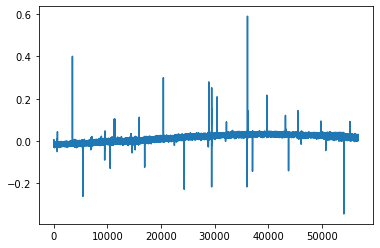

In [20]:
plt.plot(np.diff(gnssutm[0]))

In [21]:
gnssdayseconds[0:5]

[25161.0, 25161.5, 25162.0, 25162.5, 25163.0]

## Load  GEM2 data to be drift corrected

In [22]:
gem2inputfile = "/mnt/documents/JC2-2/P10-11092021/gem2/processed-survey/JC2-2-P10-transect-gem2-531-channel-thickness.csv"

In [23]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [24]:
gem2data

time   record_id   longitude   latitude   xc  \
0      2021-09-12T07:38:54.171875           0    0.000000   0.000000  0.0   
1      2021-09-12T07:38:54.273437           1    0.000000   0.000000  0.0   
2      2021-09-12T07:38:54.375000           2  -16.687000  86.392902  0.0   
3      2021-09-12T07:38:54.476562           3  -16.687001  86.392902  0.0   
4      2021-09-12T07:38:54.578125           4  -16.687001  86.392902  0.0   
...                           ...         ...         ...        ...  ...   
66417  2021-09-12T13:45:28.062500       66417    0.000000   0.000000  0.0   
66418  2021-09-12T13:45:28.156250       66418    0.000000   0.000000  0.0   
66419  2021-09-12T13:45:28.250000       66419    0.000000   0.000000  0.0   
66420  2021-09-12T13:45:28.359375       66420    0.000000   0.000000  0.0   
66421  2021-09-12T13:45:28.453125       66421    0.000000   0.000000  0.0   

        yc  f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
0      0.0         0.225         0.832          0.953          0.858   
1      0.0         1.053         0.848          0.892          0.855   
2      0.0         1.467         0.860          0.873          0.853   
3      0.0         1.054         0.879          0.889          0.853   
4      0.0         0.856         0.859          0.945          0.844   
...    ...           ...           ...            ...            ...   
66417  0.0         0.960         1.384          1.256          1.377   
66418  0.0         1.279         1.395          1.291          1.399   
66419  0.0         1.211         1.427          1.277          1.409   
66420  0.0         1.510         1.419          1.382          1.412   
66421  0.0         1.643         1.363          1.340          1.375   

       f5310Hz_hcp_i   f5310Hz_hcp_q  f18330Hz_hcp_i   f18330Hz_hcp_q  \
0              0.879           0.852           0.863            0.841   
1              0.866           0.850           0.862            0.842   
2              0.858           0.851           0.860            0.842   
3              0.862           0.852           0.860            0.841   
4              0.861           0.851           0.863            0.842   
...              ...             ...             ...              ...   
66417          1.357           1.401           1.390            1.407   
66418          1.346           1.407           1.389            1.404   
66419          1.361           1.407           1.386            1.406   
66420          1.363           1.404           1.390            1.408   
66421          1.356           1.402           1.390            1.406   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
0               0.856            0.773  
1               0.856            0.775  
2               0.856            0.777  
3               0.854            0.778  
4               0.854            0.776  
...               ...              ...  
66417           1.402            1.407  
66418           1.400            1.407  
66419           1.401            1.407  
66420           1.403            1.408  
66421           1.402            1.403  

[66422 rows x 16 columns]

In [25]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [26]:
gem2data

time   record_id   longitude   latitude   xc  \
2      2021-09-12T07:38:54.375000           2  -16.687000  86.392902  0.0   
3      2021-09-12T07:38:54.476562           3  -16.687001  86.392902  0.0   
4      2021-09-12T07:38:54.578125           4  -16.687001  86.392902  0.0   
5      2021-09-12T07:38:54.671875           5  -16.687002  86.392902  0.0   
6      2021-09-12T07:38:54.773437           6  -16.687002  86.392902  0.0   
...                           ...         ...         ...        ...  ...   
66412  2021-09-12T13:45:27.562500       66412  -16.634363  86.385000  0.0   
66413  2021-09-12T13:45:27.656250       66413  -16.634367  86.385000  0.0   
66414  2021-09-12T13:45:27.750000       66414  -16.634370  86.385000  0.0   
66415  2021-09-12T13:45:27.859375       66415  -16.634373  86.385000  0.0   
66416  2021-09-12T13:45:27.953125       66416  -16.634377  86.385000  0.0   

        yc  f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
2      0.0         1.467         0.860          0.873          0.853   
3      0.0         1.054         0.879          0.889          0.853   
4      0.0         0.856         0.859          0.945          0.844   
5      0.0         1.441         0.847          0.817          0.845   
6      0.0         1.457         0.820          0.796          0.855   
...    ...           ...           ...            ...            ...   
66412  0.0         1.772         1.396          1.254          1.414   
66413  0.0         1.912         1.372          1.183          1.407   
66414  0.0         2.026         1.366          1.165          1.400   
66415  0.0         1.760         1.343          1.229          1.376   
66416  0.0         0.976         1.352          1.237          1.361   

       f5310Hz_hcp_i   f5310Hz_hcp_q  f18330Hz_hcp_i   f18330Hz_hcp_q  \
2              0.858           0.851           0.860            0.842   
3              0.862           0.852           0.860            0.841   
4              0.861           0.851           0.863            0.842   
5              0.861           0.852           0.865            0.843   
6              0.869           0.852           0.861            0.842   
...              ...             ...             ...              ...   
66412          1.361           1.400           1.386            1.409   
66413          1.373           1.397           1.388            1.409   
66414          1.379           1.395           1.388            1.409   
66415          1.367           1.391           1.388            1.410   
66416          1.347           1.391           1.388            1.411   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
2               0.856            0.777  
3               0.854            0.778  
4               0.854            0.776  
5               0.854            0.775  
6               0.855            0.780  
...               ...              ...  
66412           1.403            1.412  
66413           1.403            1.410  
66414           1.403            1.407  
66415           1.403            1.408  
66416           1.403            1.411  

[66007 rows x 16 columns]

In [27]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [28]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [29]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

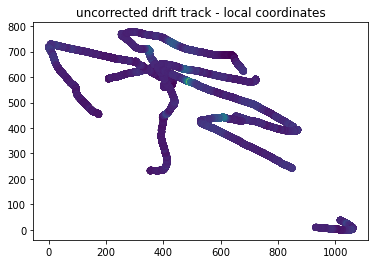

In [30]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [31]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour))*3600.0) + (int(minute) * 60.0) + float(second))

In [32]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [33]:
gem2times[-2]

'2021-09-12T13:45:27.859375'

In [34]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

27534.375
4746
48734


In [35]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [36]:
gnss_trimmedtime

array([ 4746,  4747,  4748, ..., 48732, 48733, 48734])

In [37]:
start

27534.375

In [38]:
end

49527.9531

In [39]:
gnssdayseconds = np.array(gnssdayseconds)

In [40]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [41]:
trimmedtime[0]

27534.0

In [42]:
gem2dayseconds[0]

27534.375

In [43]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [44]:
timesteps = np.round(timesteps, 4)

In [45]:
timesteps[0]

27533.5

In [46]:
gem2dayseconds[0]

27534.375

In [47]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 1h 58min 7s, sys: 14min 50s, total: 2h 12min 57s
Wall time: 2h 12min 58s


In [53]:
len(timeindexes)

66007

In [54]:
len(gem2dayseconds)

66007

In [55]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

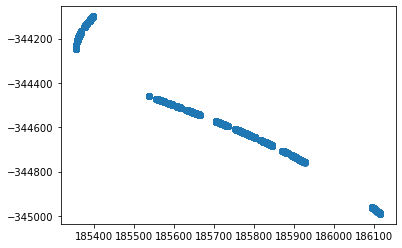

In [56]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [57]:
gnss_gem2_match_eastings[0]

array([185397.60487536])

In [58]:
len(gnss_gem2_match_eastings)

66007

In [59]:
len(gem2easting)

66007

In [60]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [61]:
gnss_gem2_match_eastings[0]

185397.60487536367

In [62]:
gem2easting[0]

185385.50032040372

In [63]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [64]:
local_gem2_east[0]

-12.104554959951201

In [65]:
local_gem2_north[0]

-11.720672793861013

In [66]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [67]:
world_gem2_east.size

66007

In [68]:
gnss_gem2_match_eastings[0]

185397.60487536367

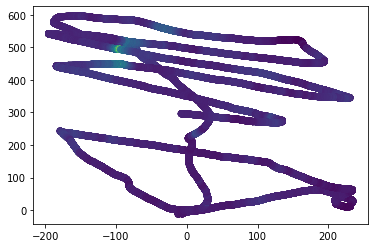

In [69]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [70]:
gem2_header = """AeN JC2-2 P10 GEM2 measurements
GEM2-531 electromagnetic induction sounder
12 September 2021\nAdam Steer / Anca Cristea
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [71]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [72]:
gem2out = gem2data.copy()

In [73]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [74]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [75]:
gem2out.insert(2, "easting", world_gem2_east)

In [76]:
gem2out.insert(3, "northing", world_gem2_north)

In [77]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [78]:
gem2_output = "/mnt/documents/JC2-2/P10-11092021/gem2/GEM2data-12092021-driftcorrected.csv"

In [79]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [80]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the Alaska Magnaprobe we need to add 8 hours to timestamps...

In [81]:
magnaprobeinputfile = "/mnt/documents/JC2-2/P10-11092021/magnaprobe/12092021/NPI4.dat"


In [82]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [83]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [84]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [85]:
weekdelta = timedelta(weeks=1024)

In [86]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [87]:
mprawtimes[100]

'2002-01-27 07:44:40.5'

In [88]:
datetime.strptime(mprawtimes[0], "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 8)

datetime.datetime(2002, 1, 27, 15, 37, 17, 660000)

In [89]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [90]:
mptimes

array(['07:37:17.66', '07:37:22.04', '07:37:23.64', ..., '14:34:50.25',
       '14:34:52.27', '14:34:53.92'], dtype='<U11')

In [91]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [92]:
mp_dayseconds = np.round(mp_dayseconds, 2)
mp_dayseconds

array([27437.66, 27442.04, 27443.64, ..., 52490.25, 52492.27, 52493.92])

In [93]:
gnssdayseconds

array([25161. , 25161.5, 25162. , ..., 53558. , 53558.5, 53559. ])

In [94]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

27437.66
4553
54666


In [95]:
gnssdayseconds = np.array(gnssdayseconds)

In [96]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [97]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [98]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 6.09 s, sys: 0 ns, total: 6.09 s
Wall time: 6.08 s


In [99]:
len(timeindexes)

5610

In [100]:
len(mp_dayseconds)

5610

In [101]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [102]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [103]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [104]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

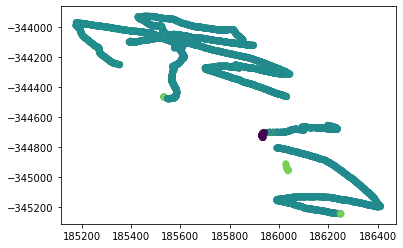

In [105]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [106]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [107]:
len(mpeasting)

5610

In [108]:
len(gnss_mp_match_eastings)

5610

Convert back to world coordinates

In [109]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

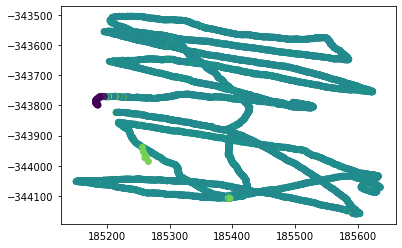

In [110]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [111]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [112]:
mp_timefixed[0]

'12-09-2021T07:37:17.66'

In [113]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [114]:
mp_output = "/mnt/documents/JC2-2/P10-11092021/magnaprobe/MPdata-driftcorrected-datefixed-12092021.csv"

In [115]:
mp_header = """AeN JC2-2 2021 P10 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
12 September 2021\nAdam Steer / Anca Cristea
Time corrected: adding 9 hours to instrument timestamps to account for time zone settings
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [116]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [117]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

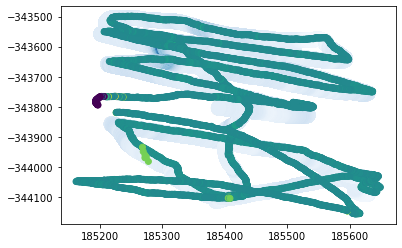

In [118]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

### first get the drift track for the right day

In [160]:
cam_glon, cam_glat, cam_gtimes = readbasegps("/mnt/documents/JC2-2/P10-11092021/gnss/base3-near/nav/P10-base3-day1-11092021.pos",
                               skiptherows = 13)

Index(['%  UTC                 ', ' latitude(deg)', 'longitude(deg)',
       ' height(m)', '  Q', ' ns', '  sdn(m)', '  sde(m)', '  sdu(m)',
       ' sdne(m)', ' sdeu(m)', ' sdun(m)', 'age(s)', ' ratio'],
      dtype='object')
['2021/09/11 07:44:29.000' '2021/09/11 07:44:29.500'
 '2021/09/11 07:44:30.000' '2021/09/11 07:44:30.500']


In [161]:
cam_glat[0:5]

array([86.49266959, 86.49266933, 86.49266901, 86.49266868, 86.49266847])

In [162]:
cam_gtimes[-1]

datetime.datetime(2021, 9, 11, 15, 10, 12)

In [163]:
gnssdayseconds=[]
for thetime in cam_gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [164]:
cam_gnssutm = thetransform.transform(cam_glat, cam_glon)
cam_gnssutm = np.array(cam_gnssutm)

In [165]:
cameracentrefile = "/mnt/documents/ANAFI-USA/jc2-2/11092021-jc2-2-p10/cameracenters.csv"

In [166]:
cameradata = pd.read_csv(cameracentrefile)

In [167]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [168]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [169]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

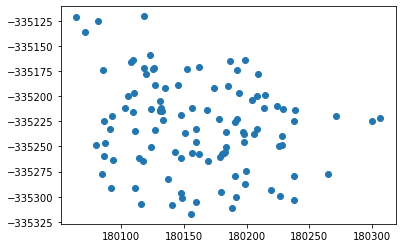

In [170]:
plt.scatter(cameraeasting, cameranorthing)

In [171]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    jpg/P1354045.JPG  2021:09:11 11:21:27                 597    86.488125   
1    jpg/P1354046.JPG  2021:09:11 11:21:33                 775    86.488120   
2    jpg/P1354047.JPG  2021:09:11 11:21:43                  21    86.488113   
3    jpg/P1354048.JPG  2021:09:11 11:21:46                 592    86.488139   
4    jpg/P1354049.JPG  2021:09:11 11:21:57                 922    86.488199   
..                ...                  ...                 ...          ...   
102  jpg/P1354147.JPG  2021:09:11 11:33:08                 334    86.487887   
103  jpg/P1354148.JPG  2021:09:11 11:33:11                 256    86.487784   
104  jpg/P1354149.JPG  2021:09:11 11:33:22                 579    86.487554   
105  jpg/P1354150.JPG  2021:09:11 11:33:25                 470    86.487558   
106  jpg/P1354151.JPG  2021:09:11 11:33:28                 599    86.487534   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0      -16.748179    -1.103659             4.517973       0.652993   
1      -16.748143     5.469987             9.404469       0.796492   
2      -16.747998    12.521273            16.153917       0.781025   
3      -16.747854    20.124989            24.915993       0.830963   
4      -16.747529    43.236923            50.189247       0.896437   
..            ...          ...                  ...            ...   
102    -16.737628    30.059410            37.382366       0.857030   
103    -16.740699    27.640207            37.063164       0.898721   
104    -16.744662    17.800077            27.670246       0.756902   
105    -16.744431    11.877670            21.504314       0.764199   
106    -16.745131     6.242649            15.112800       0.778974   

     GPSZAccuracy  CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0             1.5         -52.732147          0.006781        99.682648  
1             1.7         -55.905945         -0.004973        99.844246  
2             1.6         -63.613392          0.000983        99.797859  
3             1.7         -63.614498         -0.011822        99.651993  
4             1.8         -63.628143          0.053127        99.485573  
..            ...                ...               ...              ...  
102           1.6         -73.588760         -0.331151      -118.102821  
103           1.7         -73.467972         -0.238878      -118.585213  
104           1.4         -73.481850         -0.221127       -12.706433  
105           1.4         -73.454361          0.149856       -13.609260  
106           1.4         -73.377136          0.162631       -13.633059  

[107 rows x 12 columns]

In [172]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [173]:
cam_utm = np.array(cam_utm)

In [174]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [175]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.597, 0.775, 0.21, 0.592, 0.922]

In [176]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1
cam_dayseconds = np.array(cam_dayseconds)

In [177]:
cam_dayseconds[0]

33660.597

In [178]:
cam_gnssutm

array([[ 179848.56593363,  179848.57438289,  179848.5881902 , ...,
         182657.85664455,  182657.91421485,  182657.97113038],
       [-334806.25711362, -334806.28457514, -334806.31592775, ...,
        -337422.99001449, -337423.07277352, -337423.14811947]])

In [179]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

33660.597
11583
13024


In [180]:
gnssdayseconds = np.array(gnssdayseconds)

In [181]:
len(cam_dayseconds)

107

In [182]:
trimmedeast = np.squeeze(cam_gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(cam_gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [183]:
len(trimmedeast)

1442

In [184]:
min(cam_dayseconds)

33660.21

In [185]:
max(cam_dayseconds)

34380.615

In [186]:
min(gnssdayseconds)

27869.0

In [187]:
max(gnssdayseconds)

54612.0

In [188]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [189]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 33.6 ms, sys: 3.19 ms, total: 36.8 ms
Wall time: 36 ms


In [190]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [191]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [192]:
local_cam_east[0]

-0.11935935076326132

In [193]:
local_cam_north[0]

-1.3675588455516845

In [194]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

44.93861321755685

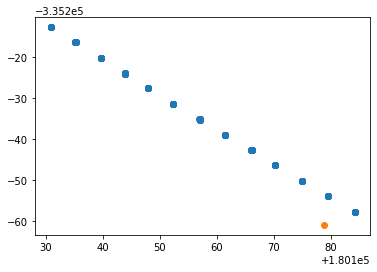

In [195]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting[-1], cameranorthing[-1])

In [196]:
cameraeasting[0]

180130.7386980372

In [197]:
gem2easting[0]

185385.50032040372

In [198]:
cameranorthing[0]

-335214.05679423764

In [199]:
gem2northing[0]

-344111.17402665183

In [200]:
local_gem2_east[0]

-12.104554959951201

In [201]:
local_mp_east[0]

-2.3764870518934913

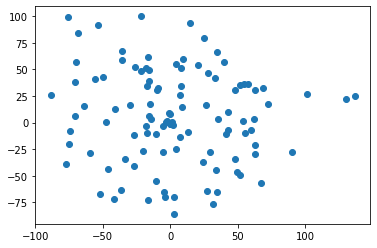

In [202]:
plt.scatter(local_cam_east, local_cam_north)

In [203]:
gnss_gem2_match_eastings[0]

185397.60487536367

In [204]:
local_gem2_east[0]

-12.104554959951201

In [209]:
world_cam_east = local_cam_east + gnss_gem2_match_eastings[0]
world_cam_north = local_cam_north + gnss_gem2_match_northings[0]

In [210]:
world_cam_east[0]

185397.4855160129

In [211]:
world_gem2_east[0]

185385.50032040372

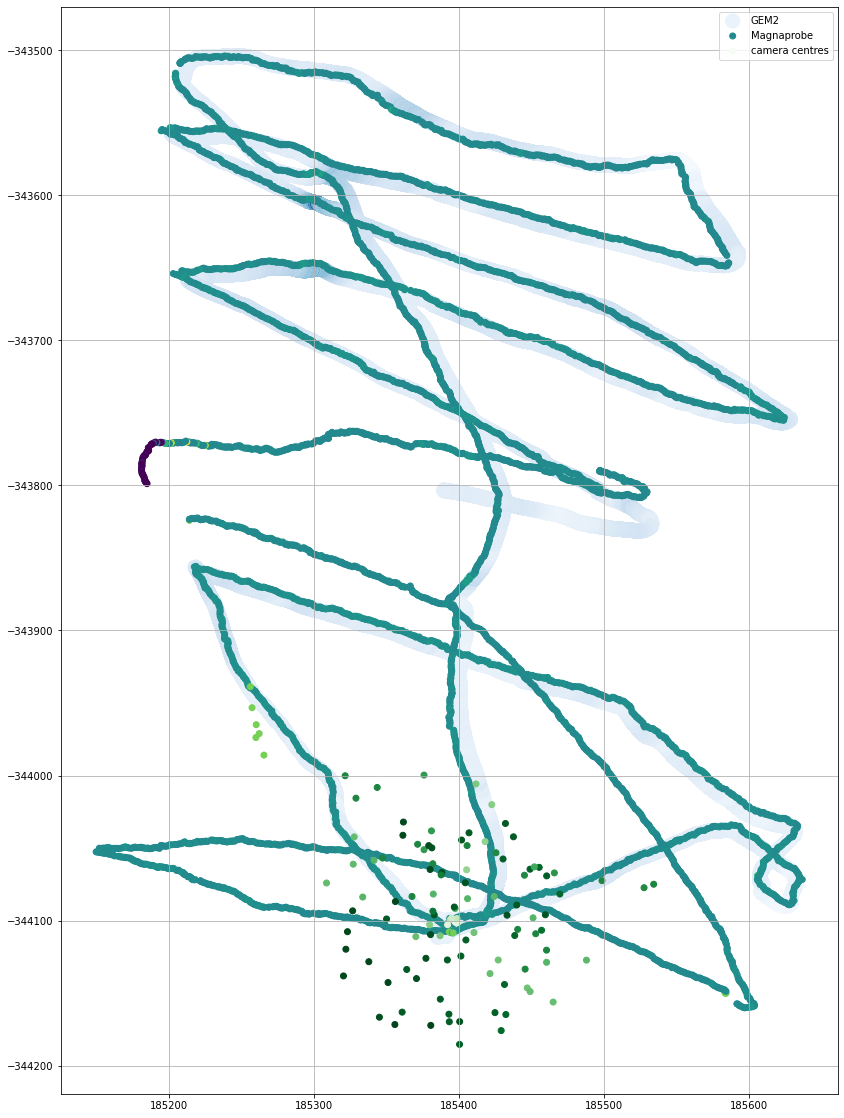

In [212]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP6-09052021/driftracks.png")

In [213]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [214]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [215]:
cam_out = cameradata.copy()

In [216]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [217]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [218]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/jc2-2/11092021-jc2-2-p10/driftcorrected-for-exiftool.csv"

In [219]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [220]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

-0.09519133504856825

In [221]:
cam_out['GPSLatitude'][0]

86.39293333161814

cam_o

In [222]:
cam_out_hag = cam_out.copy()

In [223]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [224]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [225]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/jc2-2/11092021-jc2-2-p10/driftcorrected-for-exiftool-HAG.csv"

In [226]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)